In [136]:
import pandas as pd
import html
import re

# Define the data type for column 14 as 'str'
dtype_options_UK = {14: 'str'}
# Set options to display all rows and remove ellipsis for cell content
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full text in columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping

# Load the CSV file into a Pandas DataFrame with specified data types
df_UK = pd.read_csv('data/UK-R-migr-RA-twit-meta-2012-2022.csv', dtype=dtype_options_UK)

# if data__id is NaN, then drop the row
# this helps to remove the rows that are not tweets and were used as segmentations in the original dataset
df_UK = df_UK.dropna(subset=['data__id'])

# reinitialize the index of the dataframe
df_UK = df_UK.reset_index(drop=True)

# columns of the dataframe to keep
keep_columns = ['data__id', 'data__text', 'data__lang', 'data__created_at', 'author__username', 'data__public_metrics__retweet_count',
                'data__public_metrics__reply_count', 'data__public_metrics__like_count', 'data__public_metrics__quote_count', 'data__source', 'data__entities__urls__unwound_url']

# Creating a new dataframe with only the columns we want
df_UK = df_UK[keep_columns]

# Define a function to perform the required operations on each text string
def preprocess_text(text):
    # Remove http or https or www link if present
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove "RT <str>: " or "RT <string>:" if present
    text = re.sub(r'^RT\s.*?:\s*', '', text)
    return text
    
# additionally, create a new column with the data__text cleaned from URLs
df_UK['data__text_without_links'] = df_UK['data__text'].apply(preprocess_text)
    
# convert the dataframe to datetime
df_UK['data__created_at'] = pd.to_datetime(df_UK['data__created_at'])

# rearrange the columns to the following order
rearrange_columns = ['data__id', 'data__text', 'data__text_without_links', 'data__entities__urls__unwound_url', 'data__lang', 'data__created_at', 'author__username',
         'data__public_metrics__retweet_count', 'data__public_metrics__reply_count', 'data__public_metrics__like_count', 'data__public_metrics__quote_count', 'data__source']
df_UK = df_UK[rearrange_columns]

# Remove rows where 'data__text_without_links' is NaN or an empty string
df_UK = df_UK.dropna(subset=['data__text_without_links'])
df_UK = df_UK[df_UK['data__text_without_links'] != '']
df_UK = df_UK[df_UK['data__text_without_links'] != ' ']

# load the 'data__text_without_links' from the UK dataset as docs_UK
docs_UK = [html.unescape(tweet) for tweet in df_UK['data__text_without_links'].tolist()]

""" for each @username or @user_name in the tweets, replace it with the string 'Username' or 'User Name'"""
def replace_at_mentions(sentence):
    # Define a regular expression pattern to match @ followed by one or more word characters
    pattern = r'@(\w+)'

    # Define a function to replace each match with its capitalized version with spaces
    def replace(match):
        return ' '.join(word.capitalize() for word in match.group(1).split('_'))

    # Use re.sub to perform the replacement
    replaced_sentence = re.sub(pattern, replace, sentence)

    return replaced_sentence

# Apply the function to each tweet in the dataset
docs_UK = [replace_at_mentions(tweet) for tweet in docs_UK]

docs_UK[:5]

["John Denham can't bring himself to admit immigration is too high. If Labour can't do that, this 'apology' is meaningless.",
 'Just raised issue in HofC of support for Syrian refugees in Turkey, with Foreign Sec, encouraging response with financial support.',
 'We made a clear promise to the British public ... this gov would reduce and control immigration - Home Secretary ',
 '‘We’re delivering on our promise to control immigration’ – Home Secretary Theresa May ',
 'In her speech today the Home Secretary addressed some common misconceptions about immigration ']

In [2]:
# save the docs to a file
with open('data/docs_UK.txt', 'w', encoding='utf-8') as filehandle:
    for listitem in docs_UK:
        filehandle.write('%s\n' % listitem)

In [3]:
import pandas as pd
from tqdm import tqdm
from span_marker import SpanMarkerModel

# Download from the 🤗 Hub
ner_model = SpanMarkerModel.from_pretrained("tomaarsen/span-marker-mbert-base-multinerd")
# put the model on the GPU
ner_model = ner_model.to('cuda')

# create a list to store the results
ner_data = []

# iterate over the tweets and store the results in the list
for tweet in tqdm(docs_UK):
    ner_results = ner_model.predict(tweet)
    for entity in ner_results:
        ner_data.append({
            'tweet': tweet,
            'label': entity['label'],
            'score': entity['score'],
            'word': entity['span'],
            'start': entity['char_start_index'],
            'end': entity['char_end_index']
        })

# create a DataFrame from the list
df_ner = pd.DataFrame(ner_data)

# drop the rows where the word is more than two words
df_ner = df_ner[df_ner['word'].str.split().str.len() <= 2]

# save it in a csv file
df_ner.to_csv('data/UK-R-migr-RA-twit-meta-2012-2022-ner.csv', index=False)

100%|██████████| 6461/6461 [04:45<00:00, 22.66it/s]


In [4]:
df_ner.head(10)

,tweet,label,score,word,start,end
0,"John Denham can't bring himself to admit immigration is too high. If Labour can't do that, this 'apology' is meaningless.",PER,0.999952,John Denham,0,11
1,"John Denham can't bring himself to admit immigration is too high. If Labour can't do that, this 'apology' is meaningless.",ORG,0.998431,Labour,69,75
2,"Just raised issue in HofC of support for Syrian refugees in Turkey, with Foreign Sec, encouraging response with financial support.",LOC,0.998696,Turkey,60,66
3,"Just raised issue in HofC of support for Syrian refugees in Turkey, with Foreign Sec, encouraging response with financial support.",ORG,0.984956,Foreign Sec,73,84
4,We made a clear promise to the British public ... this gov would reduce and control immigration - Home Secretary,LOC,0.874309,British,31,38
5,‘We’re delivering on our promise to control immigration’ – Home Secretary Theresa May,PER,0.999986,Theresa May,74,85
6,In her speech today the Home Secretary addressed some common misconceptions about immigration,PER,0.515802,Home Secretary,24,38
7,"Home Sec:'We’ve taken action across the board. We’ve capped economic migration, reformed family visas, & cut out abuse of student route.'",ORG,0.975605,Home Sec,0,8
8,Read Home Secretary Theresa May’s speech: 'An Immigration System that Works in the National Interest',PER,0.999978,Theresa May,20,31
9,How we are reducing net migration,ANIM,0.587485,net migration,20,33


In [5]:
# find the unique labels
df_ner['label'].unique()

array(['PER', 'ORG', 'LOC', 'ANIM', 'DIS', 'TIME', 'FOOD', 'EVE', 'MEDIA',
       'CEL', 'MYTH', 'VEHI', 'PLANT', 'INST'], dtype=object)

In [6]:
# Create a dictionary to store the counts of each word for each entity group
def unique_entities(df_ner):
    # Step 1: Create a list of unique labels
    unique_labels = df_ner['label'].unique()

    # Step 2 & 3: Create a nested dictionary to store unique words and their counts for each label
    label_word_counts = {}
    for label in unique_labels:
        # Filter the DataFrame for the current label
        label_df = df_ner[df_ner['label'] == label]
        # Get unique words for the current label
        unique_words = label_df['word'].unique()
        # Initialize dictionary to store word counts for the current label
        word_counts = {}
        # Iterate over unique words for the current label
        for word in unique_words:
            # Count occurrences of the word for the current label
            count = label_df[label_df['word'] == word]['tweet'].nunique()
            # Add the word and its count to the dictionary
            word_counts[word] = count
        # Add the dictionary of word counts to the nested dictionary with the label as key
        label_word_counts[label] = word_counts

    # drop the word keys from the dict if they contain only one character
    for label, word_counts in label_word_counts.items():
        label_word_counts[label] = {word: count for word, count in word_counts.items() if len(word) > 1}

    return label_word_counts

# check if any substring of the word is present in the keys of the dict, if yes, then add the count to the longer word
def merge_substrings(entity_group_dict):
    # Create a new dictionary to store the updated counts
    updated_entity_group_dict = {}
    # Iterate over each entity group dictionary
    for entity_group, entity_dict in entity_group_dict.items():
        # Initialize a new dictionary to store updated counts for this entity group
        updated_entity_dict = {}
        # Get the list of keys
        keys = list(entity_dict.keys())
        # Iterate over each key
        for key1 in keys:
            # Initialize the count for this key
            count = entity_dict[key1]
            # Check if the key is at least 2 characters long
            if len(key1) >= 2:
                # Check if the key is a substring of any other key
                for key2 in keys:
                    if key1 != key2 and len(key2) > len(key1) and key1 in key2:
                        # Add the count of string1 to string2
                        count += entity_dict[key1]
                        break  # Exit the loop once a match is found to avoid redundant comparisons
            # Add the key and its updated count to the updated entity dictionary
            updated_entity_dict[key1] = count
        # Add the updated entity dictionary to the updated entity_group_dict
        updated_entity_group_dict[entity_group] = updated_entity_dict

    return updated_entity_group_dict

# Update the entity_group_dict
entity_group_dict = merge_substrings(unique_entities(df_ner))


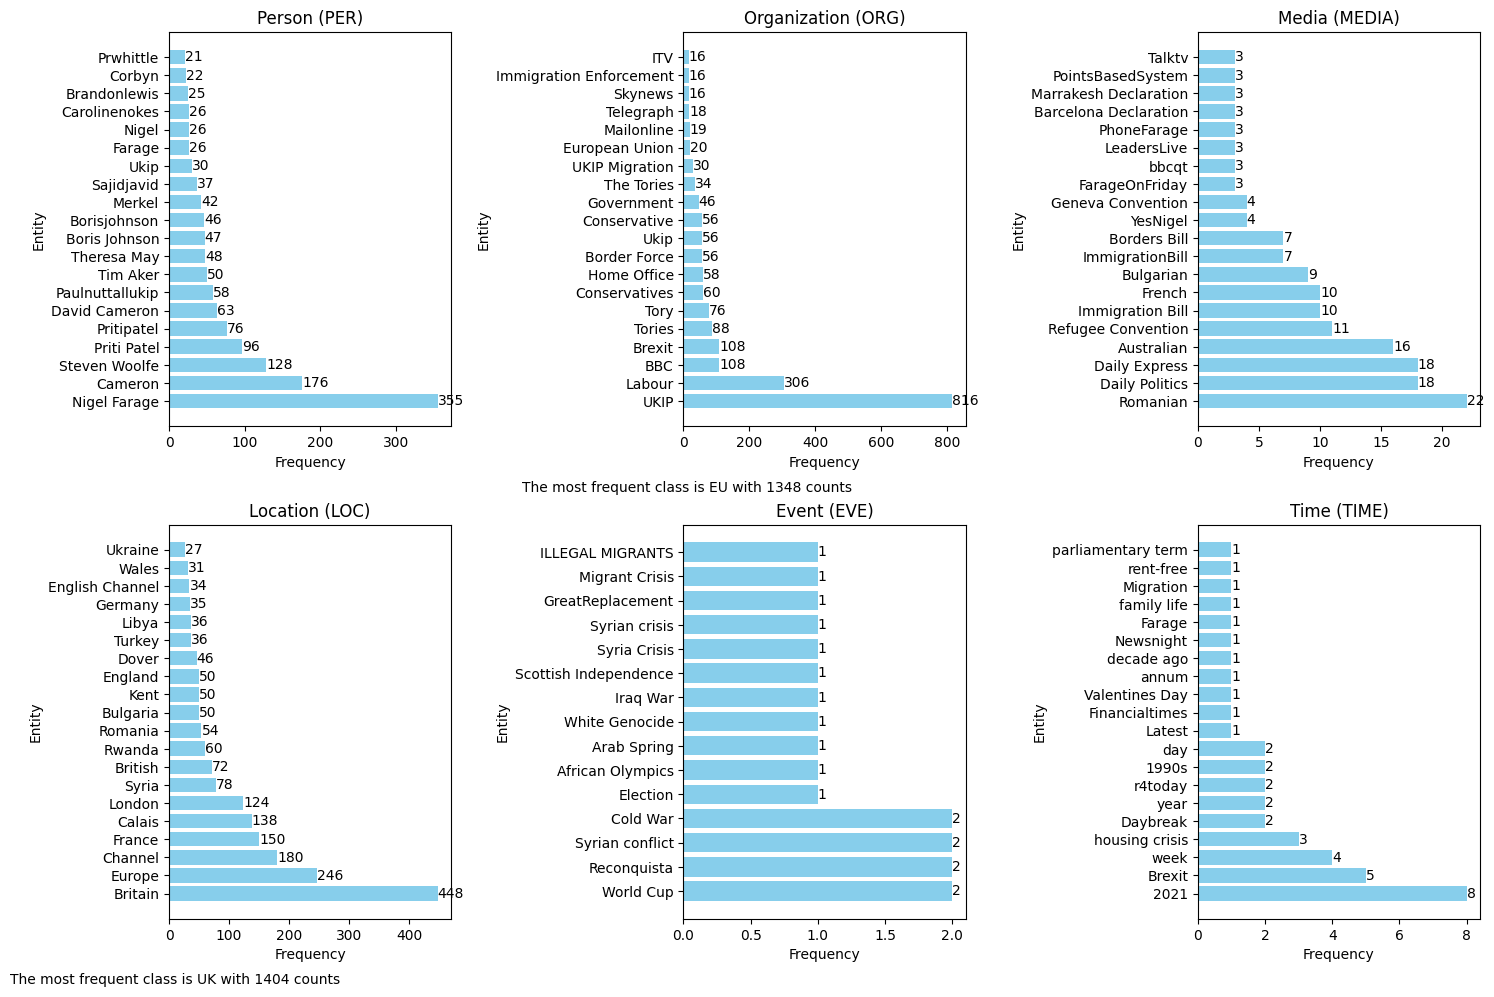

In [7]:
import matplotlib.pyplot as plt

# Title mappings
title_mappings = {'PER': 'Person', 'ORG': 'Organization', 'MEDIA': 'Media', 'LOC': 'Location', 'EVE': 'Event', 'TIME': 'Time'}

# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot for each key
for i, key in enumerate(['PER', 'ORG', 'MEDIA', 'LOC', 'EVE', 'TIME']):
    # Sort the entities based on their frequency
    sorted_entities = sorted(entity_group_dict[key].items(), key=lambda x: x[1], reverse=True)
    entities, counts = zip(*sorted_entities)
    
    # Check if the most frequent class has more than 1000 counts
    if counts[0] > 1000:
        most_frequent_class = entities[0]
        most_frequent_count = counts[0]
        # Create a wrapped footnote
        footnote_text = f"The most frequent class is {most_frequent_class} with {most_frequent_count} counts"
        axs[i // 3, i % 3].text(10, -5, footnote_text, wrap=True, ha='center', fontsize=10)
        # Remove the most frequent class
        entities = entities[1:]
        counts = counts[1:]

    # Plot
    ax = axs[i // 3, i % 3]
    bars = ax.barh(entities[:20], counts[:20], color='skyblue')
    ax.set_title(f"{title_mappings[key]} ({key})")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Entity')
    
    # Add counts inside the bars
    for bar, count in zip(bars, counts[:20]):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, count, ha='left', va='center', color='black')

# Adjust layout
plt.tight_layout()
plt.show()

'CEL', 'MYTH', 'VEHI', 'PLANT', 'INST'

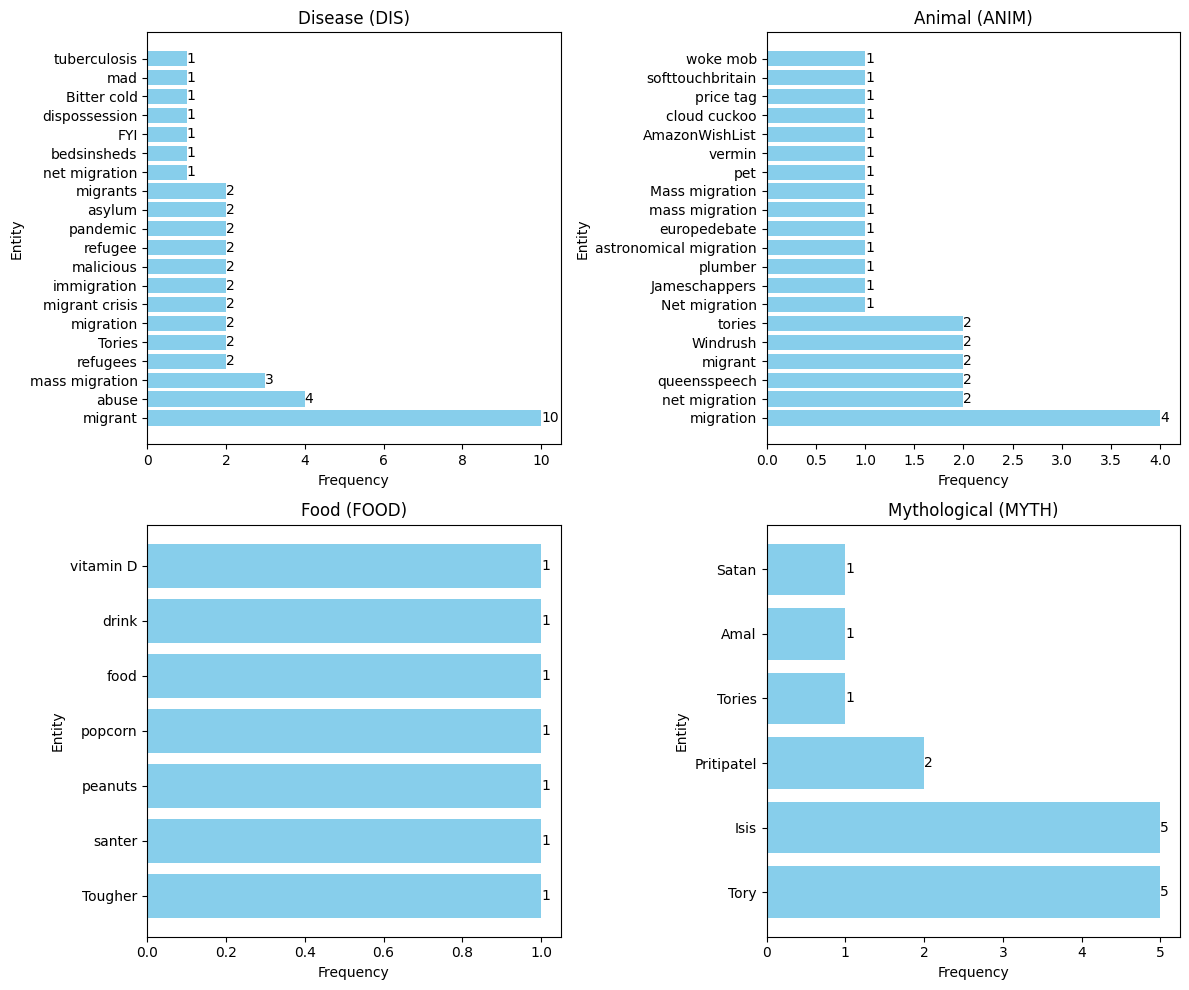

In [8]:
import matplotlib.pyplot as plt

# Title mappings
title_mappings = {'DIS': 'Disease', 'ANIM': 'Animal', 'FOOD': 'Food', 'MYTH': 'Mythological'}

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for each key
for i, key in enumerate(['DIS', 'ANIM', 'FOOD', 'MYTH']):
    # Sort the entities based on their frequency
    sorted_entities = sorted(entity_group_dict[key].items(), key=lambda x: x[1], reverse=True)
    entities, counts = zip(*sorted_entities)
    
    # Check if the most frequent class has more than 1000 counts
    if counts[0] > 1000:
        most_frequent_class = entities[0]
        most_frequent_count = counts[0]
        # Create a wrapped footnote
        footnote_text = f"The most frequent class is {most_frequent_class} with {most_frequent_count} counts"
        axs[i // 2, i % 2].text(0.5, -0.3, footnote_text, wrap=True, ha='center', fontsize=10)
        # Remove the most frequent class
        entities = entities[1:]
        counts = counts[1:]

    # Plot
    ax = axs[i // 2, i % 2]
    bars = ax.barh(entities[:20], counts[:20], color='skyblue')
    ax.set_title(f"{title_mappings[key]} ({key})")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Entity')
    
    # Add counts inside the bars
    for bar, count in zip(bars, counts[:20]):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, count, ha='left', va='center', color='black')

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
# load the ner data and the docs
df_ner = pd.read_csv('data/UK-R-migr-RA-twit-meta-2012-2022-ner.csv')
with open('data/docs_UK.txt', 'r', encoding='utf-8') as filehandle:
    docs_UK = filehandle.readlines()

In [10]:
import pandas as pd
from detoxify import Detoxify
import torch

# Check if CUDA is available, if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Detoxify model on the specified device
model = Detoxify('multilingual', device=device)

# Initialize an empty list to store the predictions
predictions = []

# Iterate over the list of sentences and make predictions
for sentence in tqdm(docs_UK):
    # Make prediction for the current sentence
    prediction = model.predict(sentence)
    
    # Append the prediction to the list
    predictions.append({'sentence': sentence,
                        'toxicity': prediction['toxicity'],
                        'severe_toxicity': prediction['severe_toxicity'],
                        'obscene': prediction['obscene'],
                        'identity_attack': prediction['identity_attack'],
                        'insult': prediction['insult'],
                        'threat': prediction['threat'],
                        'sexual_explicit': prediction['sexual_explicit']})

# Convert the list of predictions into a DataFrame
df_toxic = pd.DataFrame(predictions)
# prune df when the toxicity score is greater than 0.5
df_toxic_pruned = df_toxic[df_toxic['toxicity'] > 0.5]
# save the dataframe to a csv file
df_toxic_pruned.to_csv('data/UK-R-migr-RA-twit-meta-2012-2022-toxicity.csv', index=False)
# Display the top 10 most toxic tweets
df_toxic.sort_values(by='toxicity', ascending=False).head(10)

100%|██████████| 6461/6461 [00:34<00:00, 186.69it/s]


,sentence,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
3590,Bill Kristol: White Working Class Should be Replaced by Immigrants\n\n Fuck him - #racist #Talmudist bastard! #OBI \n,0.995714,0.130343,0.945049,0.698432,0.982531,0.042481,0.112092
2372,"... anti-immigration credibility of #Ukip and deal with ""wasted vote"" syndrome. The Tories are the real target but are too stupid to see it!\n",0.992882,0.000425,0.005839,0.001670,0.991733,0.000952,0.000899
4789,"The latest genius Ukhomeoffice idea to stop migrant boats is to put out nets. \n\nThe props will foul & boats will either drift in the shipping lanes or get dragged under when the tide rips. \n\nThis will kill people. Better to return illegals, not drown them. We are led by idiots. \n",0.992410,0.000557,0.005124,0.003591,0.984447,0.012564,0.001101
2413,"Illegal immigrants running through the Channel Tunnel without challenge - now that is really, really stupid !... \n",0.992094,0.000241,0.002229,0.011859,0.984916,0.001021,0.000445
3124,Great idea! Every #BBC report on Brexit. immigration and Syria is genuinely 'false news'. Report the lying bastards! #FalseNews \n,0.987915,0.000388,0.017778,0.001919,0.985297,0.000751,0.000593
3184,Article 50 peer says immigration is good for the UK because Britons are 'so bloody stupid': #article50 #brexit \n,0.987401,0.006047,0.511894,0.524935,0.964962,0.004199,0.011030
3139,Which is sadder? Idealistic socialists thinking #Soros is good or idiot patriots thinking capitalist Leavers will stop #immigration ?\n,0.986885,0.000129,0.002548,0.002068,0.979532,0.000361,0.000394
359,This Russian Roulette approach to immigration is stupid and completely unnecessary \n,0.986733,0.000186,0.005096,0.019364,0.964300,0.000586,0.000330
3944,Virtue-signalling idiots.\n\n'The new campaign follows an incident earlier this year in which the removal from Britain of a Somalian involved in the gang rape of a 16-year-old girl was halted after airline passengers staged a mutiny demanding his release.'\n \n,0.985537,0.000992,0.034184,0.007997,0.965389,0.002449,0.028381
6347,MUST WATCH HYPOCRISY : so many pro open borders folk admit they want refugees as long as anywhere but near them. Admit we have not got the space. Total hypocrites. \n\n\n,0.984821,0.000320,0.003243,0.001198,0.973314,0.000547,0.000385


In [82]:
# load 'data/UK-R-migr-RA-twit-meta-2012-2022-toxicity.csv'
df_toxic_pruned = pd.read_csv('data/UK-R-migr-RA-twit-meta-2012-2022-toxicity.csv')

# Initialize an empty dictionary to store the top 10 sentences for each category
top_sentences_dict = {}

# Iterate over each category and find the top 10 sentences
categories = ['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
for category in categories:
    # Sort the DataFrame by the current category in descending order
    sorted_df = df_toxic_pruned.sort_values(by=category, ascending=False)
    # Get the top 10 sentences for the current category
    top_sentences = sorted_df['sentence'].head(10).tolist()
    # Store the top sentences in the dictionary
    top_sentences_dict[category] = top_sentences

# Print the dictionary
print(top_sentences_dict)
# Convert the dict to a df
top_sentences_df = pd.DataFrame(top_sentences_dict)
# show the df without truncation
pd.set_option('display.max_colwidth', None)
# save the df to a csv file
top_sentences_df.to_csv('data/UK-R-migr-RA-twit-meta-2012-2022-toxicity-top-sentences.csv', index=False)

{'obscene': ['Bill Kristol: White Working Class Should be Replaced by Immigrants\\n\\n Fuck him - #racist #Talmudist bastard! #OBI \n', 'Looking at Ukip\'s billboard & local chap saw me. His response to their \'Stop EU immigration\' slogan: "Poles No, Pakis Yes! F*ck that!"\n', 'No shit, Sherlock!\\n#Immigration and #diversity are not victimless crimes\\n\n', 'About bloody time too!  \n', "Cameron blames Calais chaos on migrants 'swarming' through wrecked Libya. Who's the fucking genius to blame for THAT?\\n\n", 'Millions know Emma West was telling blunt truth when she said that, thanks to mass immigration our "England is f*** all." Resist!\n', "Just a reminder that the fuckers won't let the #English have ANYTHING for ourselves. But have the best #StGeorgesDay you can under foreign occupation and the Norman-Capitalist-Zionist elite who, quite simply, hate us. The feeling's mutual!\\n\n", "If the physical #Resistance to this #policestate bullshit starts in an 'enriched' area, I do hope 

In [11]:
import plotly.graph_objects as go
import textwrap

# Calculate the maximum value for each row and find the corresponding category
max_categories = df_toxic_pruned[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']].idxmax(axis=1)
eaderboard.php
# Set layout
fig.update_layout(title=f'Frequency of tweets with toxicity score > 0.5 (Total: {df_toxic_pruned.shape[0]})',
                  xaxis_title='Frequency',
                  yaxis_title='Category')

# Show plot
fig.show()

In [4]:
import re
import pandas as pd
import html

# Define a function to perform the required operations on each text string
def preprocess_text(text):
    # Remove http or https or www link if present
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove "RT <str>: " or "RT <string>:" if present
    text = re.sub(r'^RT\s.*?:\s*', '', text)
    return text

# columns of the dataframe to keep
keep_columns = ['data__id', 'data__text', 'data__lang', 'data__created_at', 'author__username', 'data__public_metrics__retweet_count',
                'data__public_metrics__reply_count', 'data__public_metrics__like_count', 'data__public_metrics__quote_count', 'data__source', 'data__entities__urls__unwound_url']

# Define the data type for problem columns as 'str'
dtype_options_French = {0: 'str', 5: 'str', 6: 'str', 7: 'str', 8: 'str', 9: 'str', 10: 'str', 
                        16: 'str', 17: 'str', 18: 'str', 19: 'str', 21: 'str', 22: 'str', 
                        25: 'str', 26: 'str', 27: 'str', 31: 'str', 34: 'str', 41: 'str', 
                        42: 'str', 43: 'str'}
# Load the DataFrame from the saved CSV file
df_French = pd.read_csv('data/FR-R-MIGR-TWIT-2011-2022_meta.csv', dtype=dtype_options_French)

# Filter out non-string values in 'data__text' column
df_French = df_French[df_French['data__text'].apply(lambda x: isinstance(x, str))]

# creating a new dataframe with only the columns we want
df_French = df_French[keep_columns]

# additionally, create a new column with the data__text cleaned from URLs
df_French['data__text_without_links'] = df_French['data__text'].apply(preprocess_text)

# Convert the 'data__created_at' column to datetime with a specified format
df_French['data__created_at'] = pd.to_datetime(df_French['data__created_at'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# Drop rows where 'data__created_at' couldn't be parsed
df_French = df_French.dropna(subset=['data__created_at'])
# rearrange the columns to the following order
rearrange_columns = ['data__id', 'data__text', 'data__text_without_links', 'data__entities__urls__unwound_url', 'data__lang', 'data__created_at', 'author__username',
         'data__public_metrics__retweet_count', 'data__public_metrics__reply_count', 'data__public_metrics__like_count', 'data__public_metrics__quote_count', 'data__source']

# rearrange the columns to the following order
df_French = df_French[rearrange_columns]

# Remove rows where 'data__text_without_links' is NaN or an empty string
df_French = df_French.dropna(subset=['data__text_without_links'])
df_French = df_French[df_French['data__text_without_links'] != '']
df_French = df_French[df_French['data__text_without_links'] != ' ']

# load the 'data__text_without_links' from the UK dataset as docs_UK
docs_French = [html.unescape(tweet) for tweet in df_French['data__text_without_links'].tolist()]

""" for each @username or @user_name in the tweets, replace it with the string 'Username' or 'User Name'"""
def replace_at_mentions(sentence):
    # Define a regular expression pattern to match @ followed by one or more word characters
    pattern = r'@(\w+)'

    # Define a function to replace each match with its capitalized version with spaces
    def replace(match):
        return ' '.join(word.capitalize() for word in match.group(1).split('_'))

    # Use re.sub to perform the replacement
    replaced_sentence = re.sub(pattern, replace, sentence)

    return replaced_sentence

# Apply the function to each tweet in the dataset
docs_French = [replace_at_mentions(tweet) for tweet in docs_French]

In [6]:
import pandas as pd
from detoxify import Detoxify
import torch
from tqdm import tqdm

# Check if CUDA is available, if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Detoxify model on the specified device
model = Detoxify('multilingual', device=device)

# Initialize an empty list to store the predictions
predictions = []

# Iterate over the list of sentences and make predictions
for sentence in tqdm(docs_French):
    # Make prediction for the current sentence
    prediction = model.predict(sentence)
    
    # Append the prediction to the list
    predictions.append({'sentence': sentence,
                        'toxicity': prediction['toxicity'],
                        'severe_toxicity': prediction['severe_toxicity'],
                        'obscene': prediction['obscene'],
                        'identity_attack': prediction['identity_attack'],
                        'insult': prediction['insult'],
                        'threat': prediction['threat'],
                        'sexual_explicit': prediction['sexual_explicit']})

# Convert the list of predictions into a DataFrame
df_toxic = pd.DataFrame(predictions)
# prune df when the toxicity score is greater than 0.5
df_toxic_pruned = df_toxic[df_toxic['toxicity'] > 0.5]
# save the dataframe to a csv file
df_toxic_pruned.to_csv('data/FR-R-MIGR-TWIT-2011-2022-tweets-toxicity.json', index=False)
# Display the top 10 most toxic tweets
df_toxic.sort_values(by='toxicity', ascending=False).head(10)

100%|██████████| 11489/11489 [01:17<00:00, 147.74it/s]


,sentence,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
3887,#Macron est un « immigrationniste » forcené. C...,0.985452,0.000206,0.003924,0.000475,0.980609,0.000434,0.000524
5987,#Valls prend les Français pour des imbéciles. ...,0.978519,0.000103,0.001613,0.004621,0.970098,0.000350,0.000203
10168,Hypocrite et menteuse ! La France n’accueille ...,0.974508,0.000124,0.001165,0.002229,0.968063,0.000255,0.000269
1108,Maudits gilets jaunes !...😉 \n En revanche la...,0.973758,0.015975,0.919578,0.202427,0.556889,0.004379,0.008690
2216,Images choquantes ? \n Voulez-vous parler de c...,0.964120,0.000076,0.002352,0.000842,0.952572,0.000152,0.000250
5417,"Pendant 5 ans, Emmanuel Macron a soigneusement...",0.960748,0.000129,0.001631,0.003773,0.938571,0.000896,0.000771
7212,#Italie saisit le bateau d’1ONG-complice? Idio...,0.960663,0.000112,0.003487,0.009675,0.932988,0.000254,0.000363
5569,"Incapable de payer le RSA l'an prochain, le 93...",0.960600,0.000067,0.000937,0.002495,0.940275,0.000207,0.000157
6830,Les Républicains lâchent un élu qui a le coura...,0.956543,0.000196,0.002159,0.041527,0.929648,0.001657,0.000420
5555,Des bobos de Sciences Po se mobilisent pour ra...,0.953750,0.000238,0.009028,0.028494,0.929391,0.001893,0.000759


In [75]:
# Initialize an empty dictionary to store the top 10 sentences for each category
top_sentences_dict = {}

# Iterate over each category and find the top 10 sentences
categories = ['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
for category in categories:
    # Sort the DataFrame by the current category in descending order
    sorted_df = df_toxic_pruned.sort_values(by=category, ascending=False)
    # Get the top 10 sentences for the current category
    top_sentences = sorted_df['sentence'].head(10).tolist()
    # Store the top sentences in the dictionary
    top_sentences_dict[category] = top_sentences

# Print the dictionary
print(top_sentences_dict)

{'obscene': ['Maudits gilets jaunes !...😉  \\n En revanche la prolifération des rats, les travaux partout, les camps de migrants, les agressions n’ont strictement rien à voir avec ce mauvais classement de Paris... ', "La génération de mes parents a fait l'effort d'apprendre le français, de respecter les lois, de travailler. Aujourd'hui, une certaine immigration vient pour dealer du shit, agresser les femmes, cracher sur la France : ces gens-là, nous devons les renvoyer chez eux. \\n  \\n #FaceÀLaRue ", "La génération de mes parents a fait l'effort d'apprendre le français, de respecter les lois, de travailler. Aujourd'hui, une certaine immigration vient pour dealer du shit, agresser les femmes, cracher sur la France : ces gens-là, nous devons les renvoyer chez eux. \\n  \\n #FaceÀLaRue ", '"Pour cacher son #bullshit européen et le bilan des députés #LR, Laurentwauquiez ment :  \\n ❌NON je ne défends pas le #Frexit. \\n ❌NON il ne veut pas ""changer"" l\'Europe mais va la continuer en pi

In [81]:
# Convert the dict to a df
top_sentences_df = pd.DataFrame(top_sentences_dict)
# show the df without truncation
pd.set_option('display.max_colwidth', None)
# save the df to a csv file
top_sentences_df.to_csv('data/FR-R-MIGR-TWIT-2011-2022-top-sentences.csv', index=False)

In [18]:
# number of tweets with toxicity score greater than 0.5
df_toxic_pruned.shape, df_toxic.shape

((107, 8), (11489, 8))

In [17]:
import plotly.graph_objects as go
import textwrap

# Calculate the maximum value for each row and find the corresponding category
max_categories = df_toxic_pruned[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']].idxmax(axis=1)

# Count occurrences of each category being the maximum
category_counts = {category: (max_categories == category).sum() for category in max_categories.unique()}

# Define color mapping
color_mapping = {
    'obscene': 'red',
    'identity_attack': 'blue',
    'insult': 'green',
    'threat': 'purple',
    'sexual_explicit': 'orange'
}

# Create bar plot
fig = go.Figure()

# Iterate over categories
for category, color in color_mapping.items():
    # Sort sentences for the selected category
    sorted_sentences = df_toxic_pruned[max_categories == category].sort_values(by=category, ascending=False)['sentence'].head(5)
    # Wrap text and add br tags
    sentence_text = '<br>'.join(['<br>'.join(textwrap.wrap(sentence, width=80)) for sentence in sorted_sentences])
    # Add trace
    fig.add_trace(go.Bar(y=[f"{category} ({category_counts.get(category, 0)})"], x=[category_counts.get(category, 0)], name=category, orientation='h', marker_color=color, hovertext=sentence_text))

# Set layout
fig.update_layout(title=f'Frequency of tweets with toxicity score > 0.5 (Total: {df_toxic_pruned.shape[0]})',
                  xaxis_title='Frequency',
                  yaxis_title='Category')

# Show plot
fig.show()

# put picture in google docs
# eng vs french: concrete examples put in the google sheets and ask for comments
# do the diachronic stuff

In [137]:
# maximum length of tweets in df_French and df_UK
max_len_French = df_French['data__text'].str.len().max()
max_len_UK = df_UK['data__text'].str.len().max()
max_len_French, max_len_UK

(385, 420)

In [155]:
compare_French = ['French political discourse on immigration and borders',
 'French political discourse on immigration and eu policies',
 "Bardella's migrant crisis discourse",
 'French political discourse on immigration: referendum proposal',
 'Immigration-crime link in urban areas',
 'controversial migrant debate in france: pushback efforts, economic motives, and human trafficking',
 'French migration policy debate',
 'European parliament votes on migration quotas and free trade agreements',
 'Economic efficiency through fraud reduction',
 'violence at calais jungle: police attacks and demands for expulsion',
 'Maritime human trafficking and complicity',
 'turkish aggression threatens european borders',
 'French media figures discuss immigration and asylum law',
 "France's political discourse on immigration and national sovereignty",
 'French opposition against global migration pact',
 'French political discourse on migration and terrorism',
 "Macron's immigration policies: national vs. european frontiers",
 "mayotte's migrant crisis: border reforms needed for compatriots' sake",
 'French political discourse on migration and federalism',
 "Eric zemmour's views on immigration and identity politics in france",
 "Italy's immigration policy reduces deaths at seait is important to note that the language used in the provided texts may be perceived as offensive or discriminatory towards certain groups, and it is not appropriate to promote or encourage such rhetoric. it is crucial to approach discussions about immigration and related issues with empathy, respect, and an understanding of the complexities involved",
 "Macron's migrant repatriation plan: eu commission satisfied with failure (#immigration #clandestine)",
 "French legislative elections 2022: opposition against macron's power grab",
 "David rachline's euroscepticism and anti-immigration stance",
 "Valérie pécresse's immigration proposals: constitutional quotas and control",
 'French political discourse on asylum and immigration',
 'French presidential elections (#zemmourpresident) - immigration, identity, security, and remigration',
 'Orban victorious in hungary: nationalism reigns supreme',
 "German political discourse on refugee policy: critique of merkel's open border stance",
 "French politician's stance on migrant priority and border control",
 'European migration politics: seeking serious change outside eu, schengen, and human rights law',
 "Stephane ravier's anti-immigration sentiments in marseille",
 'French political discourse on immigration',
 "France's immigration policies and political discourse",
 'Western european migration policies under scrutiny',
 'French political discourse on immigration and border control',
 'frontex controversy: national borders vs. eu immigration policies']

df_French_with_topics = pd.read_csv('final-topics/French/French_umap15_hdb45_reducedumap15.csv')

if compare_French == df_French_with_topics['Llama2'].tolist():
    print('The topics are the same')

The topics are the same


In [150]:
# open final-topics/UK-R-migr-RA-twit-meta-2012-2022-with-topics.csv
df_UK_with_topics = pd.read_csv('final-topics/UK/UK_umap15_hdb25_reducedumap10.csv')
df_UK_with_topics['Llama2'].tolist()

['Uk immigration policy changes',
 'Nigel farage on immigration and border control',
 'Political party platforms and manifestos',
 'Rise of far-right extremism in europe: clashes between migrants and native populations',
 'Illegal migration crisis in uk waters',
 'Brexit and border control',
 'Uk refugee resettlement efforts',
 'Uk population growth due to immigration',
 'Joint action plan for tackling migrant activity in the english channel',
 'Ukip immigration discussions on bbc radio and tv',
 "Steven woolfe's migration viewpoints as ukip spokesman",
 "Uk net migration figures under david cameron's pledge",
 'Immigration policy reforms in post-brexit uk',
 'Illegal small boat crossings crackdown: nca, enforcement agencies arrest suspects',
 "London mayor election discussions: prwhittle's stance on housing and immigration",
 'Homelessness crisis in the uk: priority misplaced between refugees and veterans',
 'Uk immigration reform',
 'Housing crisis and health service overload in the 